In [2]:
import numpy as np
import pandas as pd

all_data = pd.read_csv("../datasets/students_simple.csv")
N = 6
cols_ids = [N%5, 5 + ((N**2)%5)]
all_cols = list(all_data.columns)
cols = [all_cols[i] for i in cols_ids]
data = all_data[cols].to_numpy()
x = data[:, 0]
y = data[:, 1]

print(cols)
print(data)


['mass', 'bmi']
[[45.     3.533]
 [61.     2.623]
 [56.     2.875]
 [48.     3.375]
 [54.     3.   ]
 [58.     2.828]
 [51.     3.255]
 [62.     2.726]
 [70.     2.429]
 [72.     2.361]
 [73.     2.342]
 [64.     2.672]
 [73.     2.356]
 [68.     2.559]
 [81.     2.173]
 [84.     2.095]
 [76.     2.342]
 [90.     2.011]
 [68.     2.691]
 [95.     2.021]]


Корреляция

In [ ]:
from scipy.stats import kendalltau
from scipy.stats import rankdata
import json

def fechner(x: np.ndarray, y: np.ndarray):
    mx, my = x.mean(), y.mean()
    dx, dy = x - mx, y - my

    t = (dx * dy) > 0
    C = np.count_nonzero(t) #совпадения
    D = np.count_nonzero(~t) #не совпадения

    return (C - D) / (C + D)

def pearson(x: np.ndarray, y: np.ndarray):
    return np.corrcoef(x, y)[0,1].item()

def spearman(x: np.ndarray, y: np.ndarray):
    rx = rankdata(x, method="average")
    ry = rankdata(y, method="average")
    return pearson(rx, ry)

def kendall(x: np.ndarray, y: np.ndarray):
    rx = rankdata(x, method="average")
    ry = rankdata(y, method="average")
    r, _ = kendalltau(rx, ry)
    return r.item()

print(json.dumps({
    "Фехнер": fechner(x, y),
    "Пирсон": pearson(x, y),
    "Спирмен": spearman(x, y),
    "Кенделл": kendall(x, y)
}, indent=4, ensure_ascii=False))

{
    "Фехнер": -0.9,
    "Пирсон": -0.9606094762709692,
    "Спирмен": -0.9849454969323214,
    "Кенделл": -0.9389953457668648
}


Мы получили, что данные противоположно направлены, на что нам намекает отрицательный близкий к единице Фихнер и соответсвтвенно дисперсии отрицательны и близки к -1 тоже. Другими словами чем больше mass, тем меньше bmi (это мы можем сами проврить на выведенных данных).

Визуализация

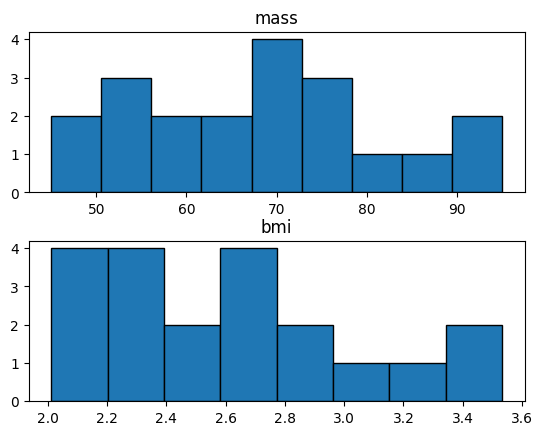

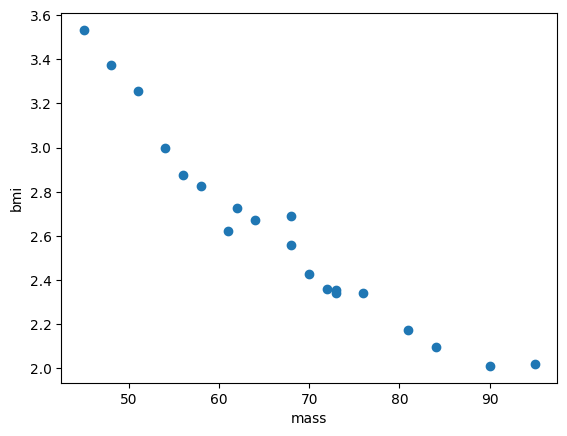

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2)
ax[0].hist(x, bins=9, edgecolor="black")
ax[1].hist(y, bins=8, edgecolor="black")
ax[0].set_title(cols[0])
ax[1].set_title(cols[1])
plt.subplots_adjust(hspace=0.3)
plt.show()

plt.scatter(x, y)
plt.xlabel(cols[0])
plt.ylabel(cols[1])
plt.show()

Гистограмма масс близка к нормальному распределению.
Гистограмма бми больше похоже на бимодальное распределение.
Либо они оба скошенные.
График рассеяния демонстрирует линию с отрицательным наклоном, что подтверждают наши выводы в 1м пункте. То что график не прямая линия, а кривая намекает на то, что нелинейные модели регрессии могут быть более точными.

Регрессия

Линейная регрессия
0.07722943409841408


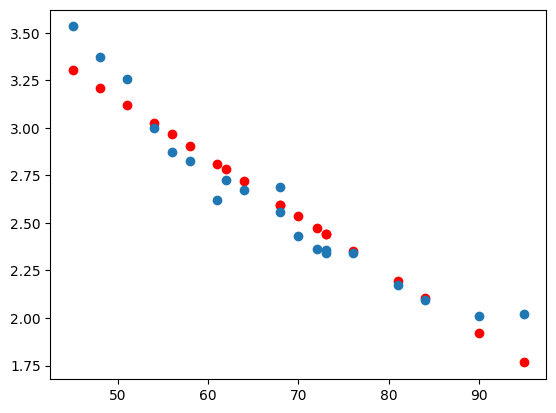

Квадратичная регрессия
0.022069761556853498


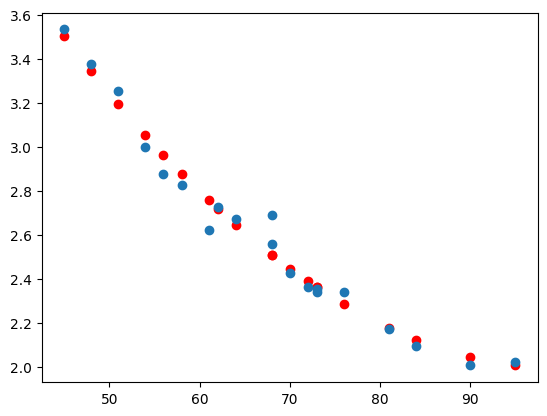

Гиперболическая регрессия
0.020867255404296004


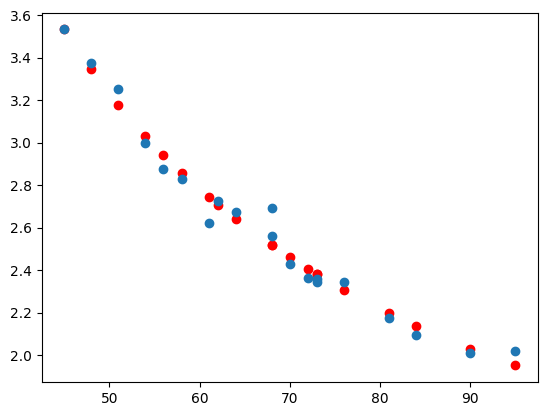

Показательная регрессия
0.04572929345312859


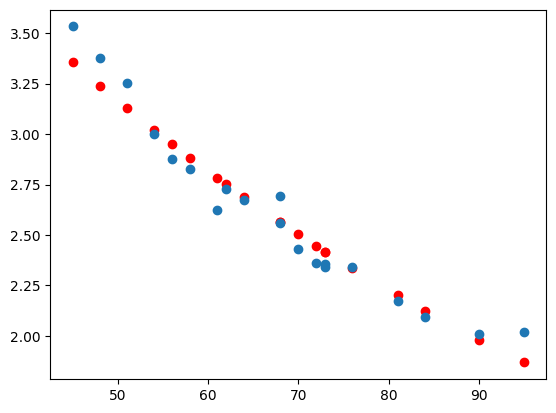

In [ ]:
from sklearn.linear_model import LinearRegression

nx = x.reshape(-1, 1)

lin_reg = LinearRegression().fit(nx, y)
sq_reg = LinearRegression().fit(np.concat([nx, nx ** 2], axis=1), y)
hyp_reg = LinearRegression().fit(1 / nx, y)
log_reg = LinearRegression().fit(nx, np.log(y))

def fisher(predict: np.ndarray, target: np.ndarray):
    num = (predict - target).std() ** 2
    den = target.std() ** 2
    return num / den

#чем ближе к 0 фишер, тем лучше

print("Линейная регрессия")
print(fisher(lin_reg.predict(nx), y))

plt.scatter(nx, lin_reg.predict(nx), color="red")
plt.scatter(nx, y)
plt.show()

print("Квадратичная регрессия")
print(fisher(sq_reg.predict(np.concat([nx, nx ** 2], axis=1)), y))

plt.scatter(nx, sq_reg.predict(np.concat([nx, nx ** 2], axis=1)), color="red")
plt.scatter(nx, y)
plt.show()

print("Гиперболическая регрессия")
print(fisher(hyp_reg.predict(1 / nx), y))

plt.scatter(nx, hyp_reg.predict(1 / nx), color="red")
plt.scatter(nx, y)
plt.show()

print("Показательная регрессия")
print(fisher(np.exp(log_reg.predict(nx)), y))

plt.scatter(nx, np.exp(log_reg.predict(nx)), color="red")
plt.scatter(nx, y)
plt.show()

Худший результат показала линейная, что мы и предполагали в прошлом пункте и что также видно на графике.
Лучшее - гиперболическая и квадратичная. Графики тоже отображают почти полное соответсвие.
Показательная средняя среди всех, ну мы можем наблюдать что оно имеет большие отклонения.